# Agents ReAct dans LangGraph : météo + calendrier

Objectifs de ce notebook:

- Construire un **agent ReAct** utilisant deux outils : `météo` et `calendrier`.
- Construire **le même comportement** avec **LangGraph** (mais workflow explicite cette fois).
- Comparer les deux approches sur plusieurs requêtes utilisateur.
- Observabilité avec Langfuse (local)

In [17]:
#!pip install -U langchain-classic langfuse
#!pip install langfuse
#!pwd
#!ls -larth

## 0. Setup du graphe

On utilise :
- un LLM local via **Ollama** ou **LM Studio** (configuré dans `.env`)
- deux outils **simulés** (pas d'API externe) :
  - `fake_get_weather` : météo simple
  - `fake_calendar_query` : créneaux d'agenda simulés

In [18]:
from typing import TypedDict, Optional, List, Literal
from datetime import datetime

import os
from dotenv import load_dotenv

from langchain_core.tools import tool
from langchain_core.prompts import ChatPromptTemplate

from langchain.agents import create_react_agent, AgentExecutor #(if version langchain < 1.0)
#from langchain_classic.agents import create_react_agent, AgentExecutor

from langgraph.graph import StateGraph, END

# from pathlib import Path
# print(Path(__file__).resolve())

# Charger les variables d'environnement depuis le fichier .env
res = load_dotenv()
# print(res)

# Configuration du LLM local
llm_type = os.getenv("LOCAL_LLM_TYPE", "local-llm")
# print(llm_type)

if llm_type == "ollama":
    from langchain_ollama import ChatOllama
    
    ollama_base_url = os.getenv("OLLAMA_BASE_URL", "http://localhost:11434")
    ollama_model = os.getenv("OLLAMA_MODEL", "local-model")
    
    llm = ChatOllama(
        model=ollama_model,
        base_url=ollama_base_url,
        temperature=0,
    )
    print(f"Utilisation d'Ollama avec le modèle {ollama_model}")
    
elif llm_type == "lmstudio":
    from langchain_openai import ChatOpenAI
    
    lmstudio_base_url = os.getenv("LMSTUDIO_BASE_URL", "http://localhost:1234/v1")
    lmstudio_model = os.getenv("LMSTUDIO_MODEL", "local-model")
    
    llm = ChatOpenAI(
        model=lmstudio_model,
        base_url=lmstudio_base_url,
        api_key="not-needed",  # LM Studio ne nécessite pas de clé API
        temperature=0,
    )
    print(f"Utilisation de LM Studio avec le modèle {lmstudio_model}")
    
else:
    raise ValueError(f"LOCAL_LLM_TYPE non reconnu: {llm_type}. Utilisez 'ollama' ou 'lmstudio'.")

# Configuration Langfuse optionnelle pour l'observabilité
# Si vous avez configuré LANGFUSE_PUBLIC_KEY et LANGFUSE_SECRET_KEY dans votre .env,
# l'observabilité sera automatiquement activée
if os.getenv("LANGFUSE_PUBLIC_KEY") and os.getenv("LANGFUSE_SECRET_KEY"):
    try:
        # from langfuse.callback import CallbackHandler
        # langfuse_handler = CallbackHandler(
        #     public_key=os.getenv("LANGFUSE_PUBLIC_KEY"),
        #     secret_key=os.getenv("LANGFUSE_SECRET_KEY"),
        #     host=os.getenv("LANGFUSE_BASE_URL", "http://localhost:3000")
        # )
        # The Langfuse 3.x API has changed
        # https://langfuse.com/integrations/frameworks/langchain
        from langfuse.langchain import CallbackHandler
        langfuse_handler = CallbackHandler()
        print(f"Langfuse activé sur {os.getenv('LANGFUSE_BASE_URL', 'http://localhost:3000')}")
    except ImportError:
        print("Langfuse non installé. Pour l'activer: pip install langfuse")
        langfuse_handler = None
else:
    langfuse_handler = None
    print("Langfuse non configuré (optionnel)")

Utilisation de LM Studio avec le modèle mistralai/devstral-small-2-2512
Langfuse non configuré (optionnel)


In [19]:
# Outil météo simulé
def fake_get_weather(period: str) -> str:
    """Simule une API météo pour 'matin', 'apres-midi' ou 'journee'."""
    if period == "matin":
        return "Ce matin : 4°C, ressenti 0°C, ciel couvert."
    elif period == "apres-midi":
        return "Cet après-midi : 16°C, pluie à partir de 15h."
    elif period == "soir":
        return "Ce soir : 9°C, orages."
    else:
        return "Aujourd'hui : entre 4°C et 16°C, avec quelques éclaircies."

# Agenda simulé : créneaux disponibles pour Julie
FAKE_SLOTS = [
    {"jour": "jeudi", "creneau": "14h-15h", "personne": "julie"},
    {"jour": "jeudi", "creneau": "16h-17h", "personne": "gabriel"},
    {"jour": "vendredi", "creneau": "10h-11h", "personne": "julie"},
]

def fake_calendar_query(person: str, jour: Optional[str] = None) -> str:
    """Renvoie des créneaux simulés pour une personne donnée."""
    if not person:
        return "Aucune personne spécifiée."
    
    slots = [s for s in FAKE_SLOTS if s["personne"].lower() == person.lower()]
    if jour:
        slots = [s for s in slots if s["jour"].lower() == jour.lower()]
    if not slots:
        return f"Aucun créneau disponible pour {person}."
    
    return f"Créneaux disponibles pour {person} : " + ", ".join(
        f"{s['jour']} {s['creneau']}" for s in slots
    )

In [20]:
QUERIES = [
    "Je veux connaître la météo de cet après-midi.",
    "Peux-tu me proposer un créneau avec Julie cette semaine ?",
    "S'il fait beau jeudi après-midi, propose-moi un créneau avec Julie.",
]

## 1. Agent ReAct (boîte noire pratique)

On crée un agent ReAct LangChain avec deux outils :

- `weather_tool(period: str)` → appelle `fake_get_weather`
- `calendar_tool(person: str, jour: Optional[str])` → appelle `fake_calendar_query`

Le framework pilote la boucle **Thought → Action → Observation**.


In [21]:
import json
import re

def parse_action_input_json(input_str: str, default_key: str = None) -> dict:
    """Parse différents formats d'Action Input (JSON, key=value, ou valeur simple)"""
    input_str = str(input_str).strip()
    
    # Format JSON
    if input_str.startswith('{'):
        try:
            return json.loads(input_str)
        except:
            pass
    
    # Format key=value (ex: person="Julie", jour="jeudi")
    result = {}
    for match in re.finditer(r'(\w+)\s*=\s*["\']?([^"\',$]+)["\']?', input_str):
        result[match.group(1)] = match.group(2).strip()
    
    if result:
        return result
    
    # Valeur simple (ex: "Julie" ou apres-midi)
    clean = input_str.replace('"', '').replace("'", '').strip()
    if default_key and clean:
        return {default_key: clean}
    
    return {}

In [22]:
@tool
def weather_tool(tool_input: str) -> str:
    """Donne la météo simulée pour 'matin', 'apres-midi', 'soir' ou 'journee'.
    
    Exemples d'utilisation:
    - apres-midi
    - period=apres-midi
    - {"period": "apres-midi"}
    """
    parsed = parse_action_input_json(tool_input, 'period')
    period = parsed.get('period', 'journee')
    #print(f"[TOOL] weather_tool: input='{tool_input}' -> period='{period}'")
    return fake_get_weather(period)

@tool
def calendar_tool(tool_input: str) -> str:
    """Renvoie des créneaux simulés pour une personne (par défaut Julie).
    
    Exemples d'utilisation:
    - julie
    - person=julie
    - person=julie, jour=jeudi
    - {"person": "julie", "jour": "jeudi"}
    """
    parsed = parse_action_input_json(tool_input)
    person = parsed.get('person', 'julie')
    jour = parsed.get('jour', parsed.get('day'))
    #print(f"[TOOL] calendar_tool: input='{tool_input}' -> person='{person}', jour='{jour}'")
    result = fake_calendar_query(person=person, jour=jour)
    #print(f"[TOOL] calendar_tool result: {result}")
    return result

tools = [weather_tool, calendar_tool]


In [23]:
# Utilisation du prompt ReAct standard de LangChain
# Ce prompt est conçu pour fonctionner correctement avec le parser ReAct
try:
    from langchain import hub
    # Récupération du prompt ReAct standard depuis LangChain Hub
    prompt = hub.pull("hwchase17/react")
except Exception:
    # Si hub.pull ne fonctionne pas, on utilise un prompt personnalisé avec le format exact ReAct
    from langchain_core.prompts import PromptTemplate
    template = """Answer the following questions as best you can. You have access to the following tools:

{tools}

Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, should be one of [{tool_names}]
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question

Begin!

Question: {input}
Thought:{agent_scratchpad}"""
    prompt = PromptTemplate.from_template(template)

react_agent = create_react_agent(llm, tools, prompt)

# Configuration de l'AgentExecutor avec Langfuse si disponible
executor_config = {
    "agent": react_agent,
    "tools": tools,
    "verbose": True,
    "handle_parsing_errors": True
}

# Ajouter le callback Langfuse si configuré
if langfuse_handler:
    executor_config["callbacks"] = [langfuse_handler]

react_executor = AgentExecutor(**executor_config)

In [24]:
print("### Démo agent ReAct (boîte noire) ###")
for q in QUERIES:
    print(f"\n=== Question: {q}")
    # Préparer la configuration avec callbacks Langfuse si disponible
    invoke_config = {"input": q}
    if langfuse_handler:
        invoke_config["callbacks"] = [langfuse_handler]
    
    result = react_executor.invoke(invoke_config)
    print("Réponse finale (ReAct):", result["output"])

### Démo agent ReAct (boîte noire) ###

=== Question: Je veux connaître la météo de cet après-midi.


> Entering new AgentExecutor chain...
Je dois utiliser l'outil `weather_tool` pour obtenir la météo simulée de cet après-midi.

Action: weather_tool
Action Input: apres-midi
Cet après-midi : 16°C, pluie à partir de 15h.Final Answer: Cet après-midi, la météo sera de 16°C avec des pluies attendues à partir de 15h.

> Finished chain.
Réponse finale (ReAct): Cet après-midi, la météo sera de 16°C avec des pluies attendues à partir de 15h.

=== Question: Peux-tu me proposer un créneau avec Julie cette semaine ?


> Entering new AgentExecutor chain...
Pour répondre à cette question, je dois vérifier les disponibilités de Julie dans son calendrier pour la semaine en cours. Je vais utiliser le `calendar_tool` avec l'argument `person=julie`.

Action: calendar_tool
Action Input: {"person": "julie"}Créneaux disponibles pour julie : jeudi 14h-15h, vendredi 10h-11hJe viens d'obtenir les créneaux dis

## 4. Agent LangGraph (workflow explicite)

On reconstruit le **même comportement** avec LangGraph :

1. Interpréter la demande (intent + paramètres)
2. Décider quels outils appeler (météo, calendrier, les deux)
3. Appeler les outils
4. Composer la réponse finale


In [35]:

IntentType = Literal["weather", "calendar", "both", "none"]

class AgentState(TypedDict):
    user_input: str
    intent: IntentType
    period: Optional[str]
    person: Optional[str]
    day: Optional[str]
    weather_result: Optional[str]
    calendar_result: Optional[str]
    final_answer: Optional[str]


In [37]:
def interpret_request(state: AgentState) -> AgentState:
    """Utilise le LLM pour classifier la demande et extraire quelques paramètres."""
    user_input = state["user_input"]
    prompt = ChatPromptTemplate.from_template(
        """Tu analyses la demande utilisateur et tu renvoies un JSON valide.

Demande: {user_input}

Répond UNIQUEMENT avec un objet JSON valide, sans texte avant ou après.
Format attendu :
{{
  "intent": "<weather|calendar|both|none>",
  "period": "<matin|apres-midi|soir|journee ou null>",
  "person": "<nom de la personne ou null>",
  "day": "<jour de la semaine ou null>"
}}

Exemples :
- "météo cet après-midi" -> {{"intent": "weather", "period": "apres-midi", "person": null, "day": null}}
- "créneau avec Julie" -> {{"intent": "calendar", "period": null, "person": "julie", "day": null}}
- "s'il fait beau jeudi, créneau avec Julie" -> {{"intent": "both", "period": "apres-midi", "person": "julie", "day": "jeudi"}}

JSON uniquement, pas d'explication :"""
    )
    messages = prompt.format_messages(user_input=user_input)
    raw = llm.invoke(messages).content.strip()

    # Extraire le JSON si le LLM ajoute du texte avant/après
    import json
    import re
    json_match = re.search(r'\{.*\}', raw, re.DOTALL)
    if json_match:
        raw = json_match.group(0)

    #print(f"[DEBUG] LLM raw response: {raw}")

    try:
        parsed = json.loads(raw)
        #print(f"[DEBUG] Parsed JSON: {parsed}")
    except json.JSONDecodeError as e:
        #print(f"[DEBUG] JSON parsing error: {e}")
        parsed = {"intent": "none", "period": None, "person": None, "day": None}

    state["intent"] = parsed.get("intent", "none")
    state["period"] = parsed.get("period")
    state["person"] = parsed.get("person")
    state["day"] = parsed.get("day")

    #print(f"[DEBUG] Extracted - intent: {state['intent']}, period: {state['period']}, person: {state['person']}, day: {state['day']}")
    return state

In [38]:
def call_weather_node(state: AgentState) -> AgentState:
    period = state.get("period") or "journee"
    #print(f"[DEBUG] Calling weather with period={period}")
    state["weather_result"] = fake_get_weather(period)
    #print(f"[DEBUG] Weather result: {state['weather_result']}")
    return state

In [39]:
def call_calendar_node(state: AgentState) -> AgentState:
    person = state.get("person") or "julie"  # Valeur par défaut
    day = state.get("day")
    #print(f"[DEBUG] Calling calendar with person={person}, jour={day}")
    state["calendar_result"] = fake_calendar_query(person=person, jour=day)
    #print(f"[DEBUG] Calendar result: {state['calendar_result']}")
    return state

In [40]:
from typing import List

def build_final_answer(state: AgentState) -> AgentState:
    parts: List[str] = []
    if state.get("weather_result"):
        parts.append(state["weather_result"])
    if state.get("calendar_result"):
        parts.append(state["calendar_result"])
    if not parts:
        parts.append("Je ne suis pas sûr de comprendre ta demande.")

    state["final_answer"] = " ".join(parts)
    return state


In [41]:

graph = StateGraph(AgentState)

graph.add_node("interpret", interpret_request)
graph.add_node("weather", call_weather_node)
graph.add_node("calendar", call_calendar_node)
graph.add_node("final", build_final_answer)

graph.set_entry_point("interpret")

def route_from_intent(state: AgentState):
    intent = state.get("intent", "none")
    if intent == "weather":
        return "weather"
    if intent == "calendar":
        return "calendar"
    if intent == "both":
        return "weather"
    return "final"

graph.add_conditional_edges(
    "interpret",
    route_from_intent,
    {
        "weather": "weather",
        "calendar": "calendar",
        "both": "weather",
        "final": "final",
    },
)

def after_weather(state: AgentState):
    if state.get("intent") == "both":
        return "calendar"
    return "final"

graph.add_conditional_edges(
    "weather",
    after_weather,
    {
        "calendar": "calendar",
        "final": "final",
    },
)

graph.add_edge("calendar", "final")
graph.add_edge("final", END)

app = graph.compile()


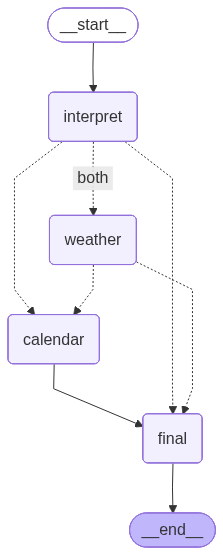

In [42]:
g = app.get_graph()

from IPython.display import Image
Image(g.draw_mermaid_png())

In [43]:

print("### Démo agent LangGraph (workflow explicite) ###")
for q in QUERIES:
    print(f"\n=== Question: {q}")
    initial_state: AgentState = {
        "user_input": q,
        "intent": "none",
        "period": None,
        "person": None,
        "day": None,
        "weather_result": None,
        "calendar_result": None,
        "final_answer": None,
    }
    result = app.invoke(initial_state)
    print("Réponse finale (LangGraph):", result["final_answer"])


### Démo agent LangGraph (workflow explicite) ###

=== Question: Je veux connaître la météo de cet après-midi.
Réponse finale (LangGraph): Cet après-midi : 16°C, pluie à partir de 15h.

=== Question: Peux-tu me proposer un créneau avec Julie cette semaine ?
Réponse finale (LangGraph): Créneaux disponibles pour julie : jeudi 14h-15h, vendredi 10h-11h

=== Question: S'il fait beau jeudi après-midi, propose-moi un créneau avec Julie.
Réponse finale (LangGraph): Cet après-midi : 16°C, pluie à partir de 15h. Créneaux disponibles pour julie : jeudi 14h-15h


## 5. Comparaison rapide : ReAct vs LangGraph

Sur ce petit exemple :

- **ReAct** :
  - On donne les outils et un prompt ReAct.
  - Le framework pilote la boucle Thought → Action → Observation.
  - Le workflow reste implicite (on le devine via les logs ou Langfuse).

- **LangGraph** :
  - On définit explicitement les étapes (interpréter, météo, calendrier, réponse).
  - On contrôle les transitions (ex : `intent == "both"` → météo puis calendrier).
  - Le même agent devient testable, observable, modifiable nœud par nœud.

En production, on peut ensuite :
- Ajouter des garde-fous,
- Limiter certains outils à certains chemins,
- Brancher Langfuse pour suivre les coûts, la latence et les erreurs par nœud.

## 6. Solution

![Solution de modification](solution.jpg)